<a href="https://colab.research.google.com/github/MatteoGioia/ViT2MLPMixerKD/blob/main/ViT2MLPKD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge distillation
In this notebook, we will try to distill the knowledge of a Vision Transformer into a MLP Mixer.

##0. Setup

### 0.1 Downloads and imports

In [1]:
#@title Downloads
!pip install -q transformers datasets[vision] pytorch-lightning
!pip install -q wandb
!pip install -q einops
!pip install -q timm

     |████████████████████████████████| 5.8 MB 19.9 MB/s 
     |████████████████████████████████| 451 kB 77.2 MB/s 
     |████████████████████████████████| 798 kB 62.0 MB/s 
     |████████████████████████████████| 182 kB 66.2 MB/s 
     |████████████████████████████████| 7.6 MB 61.1 MB/s 
     |████████████████████████████████| 125 kB 77.8 MB/s 
     |████████████████████████████████| 512 kB 73.8 MB/s 
     |████████████████████████████████| 87 kB 7.3 MB/s 
     |████████████████████████████████| 132 kB 72.3 MB/s 
     |████████████████████████████████| 212 kB 12.8 MB/s 
     |████████████████████████████████| 127 kB 8.9 MB/s 
     |████████████████████████████████| 1.9 MB 24.2 MB/s 
     |████████████████████████████████| 182 kB 75.7 MB/s 
     |████████████████████████████████| 168 kB 64.9 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 168 kB 78.2 MB/s 
     |████████████████████████████████| 166 kB 80.1 MB/s 
     |█████████████

In [28]:
#@title Imports

# general imports
from typing import *
from google.colab import drive
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import wandb

# pytorch imports
import torchvision
import pytorch_lightning as pl
from pytorch_lightning import callbacks
import transformers
#from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch
import numpy as np
import einops
import torch.nn as nn
import torch.nn.functional as F

#mlp mixer import
import timm

seed : int = 42
device : str = "cuda" if torch.cuda.is_available() else "cpu"
pl.seed_everything(seed)
print(f"You are going to train the distillation on {device}")

INFO:lightning_lite.utilities.seed:Global seed set to 42


You are going to train the distillation on cuda


In [3]:
#@title Move to the project folder
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive

if not os.path.exists("ViT2MLP"):
  os.mkdir("ViT2MLP")

%cd ViT2MLP

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/ViT2MLP


In [4]:
#@title Download the datasets
# TODO need to download it
#imagenet = torchvision.datasets.ImageNet(root = ".",split = "val")
cifar100_train = torchvision.datasets.CIFAR100(root = ".",
                                               train = True,
                                               download = True,
                                               transform=torchvision.transforms.functional.pil_to_tensor)
cifar100_test = torchvision.datasets.CIFAR100(root = ".",
                                               train = False,
                                               download = True,
                                               transform=torchvision.transforms.functional.pil_to_tensor)

Files already downloaded and verified
Files already downloaded and verified


###0.2 Utility functions

In [5]:
#@title Visualization function
def visualize(datapoint : int, dataset : torchvision.datasets):
    image, label = dataset[datapoint]
    plt.title(f"Ground truth: {dataset.classes[label]}")
    plt.imshow(torchvision.transforms.functional.to_pil_image(image))

In [6]:
#@title Function to output a prediction of the teacher
def predict(image : torch.Tensor,
            model : nn.Module,
            feature_extractor : Any = None) -> str:
    with torch.no_grad():
        if feature_extractor is None:
            logits = model(image)
        else:
            inputs : torch.Tensor = feature_extractor(image, return_tensors="pt").to(device)
            logits = model(**inputs).logits
      
    # model predicts one of the classes
    predicted_label : int = logits.argmax(-1).item()
   
    return predicted_label


In [7]:
#@title Count the parameters of a model
def count_params(model : nn.Module) -> int:
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    param_num = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
    return param_num

##1. Code for the models

###1.1 Pre-trained teacher (ViT)
Load ViT finetuned on Imagenet1k or CIFAR100. To load the non fine-tuned version use **"google/vit-base-patch16-224-im21k"**

References:
- [main transformer docs](https:huggingface.co/docs/transformers/index) 
- [ViT Docs](https://huggingface.co/docs/transformers/model_doc/vit)
- [lighting finetuning example](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/VisionTransformer)

In [ ]:
#@title Load the model
cifar100_vit = "Ahmed9275/Vit-Cifar100"
imagenet1k_vit = "google/vit-base-patch16-224"
tuned_on : str = "cifar100" #@param['cifar100', 'imagenet1k']
if tuned_on == "cifar100":
    model_str = cifar100_vit
else:
    model_str = imagenet1k_vit


feature_extractor = transformers.ViTFeatureExtractor.from_pretrained(model_str)

teacher = transformers.ViTForImageClassification.from_pretrained(model_str).to(device)
print('Trainable Parameters: %.3fM' % count_params(teacher))

Trainable Parameters: 85.876M


Predicted: lion


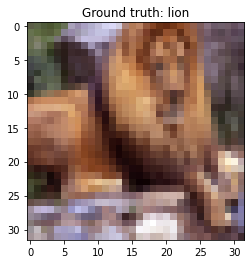

In [ ]:
#@title Qualitative comparison with ground truth {run : "auto"}
datapoint_number : int = 1200 #@param{type:"integer"}

dataset = cifar100_test if tuned_on == "cifar100" else imagenet1k
try:
    visualize(datapoint_number, dataset)
    label : int = predict(dataset[datapoint_number][0], teacher, feature_extractor)
    prediction : str = teacher.config.id2label[label]
    print(f"Predicted: {prediction}")
except IndexError:
    print(f"The dataset max index is {len(dataset)-1}")


In [ ]:
#@title Quantitative result: Accuracy
'''
Warning: this cell takes 15min to be executed (on GPU).
Anyway, after the execution we verified that the accuracy is the same.
'''
'''
correct = 0
for i in tqdm(range(len(dataset))):
    pr_label = predict(dataset[i][0], teacher, feature_extractor)
    gt_label = dataset[i][1]
    if pr_label == gt_label:
        correct += 1
accuracy = round(correct*100 / len(dataset),2)
print(f"The accuracy of the model for the dataset {tuned_on} is: {accuracy}%")
'''
##### TODO remove (?) ####

'\ncorrect = 0\nfor i in tqdm(range(len(dataset))):\n    pr_label = predict(dataset[i][0], teacher, feature_extractor)\n    gt_label = dataset[i][1]\n    if pr_label == gt_label:\n        correct += 1\naccuracy = round(correct*100 / len(dataset),2)\nprint(f"The accuracy of the model for the dataset {tuned_on} is: {accuracy}%")\n'

###1.2 Student (MLP mixer)
The code for the MLP mixer was taken from this repository: [image_models](https://github.com/rwightman/pytorch-image-models).

Credit: [Ross Wightman](https://github.com/rwightman) 

In [ ]:
#@title Our implementation
#tentative pytorch implementation for https://github.com/google-research/vision_transformer/blob/main/vit_jax/models_mixer.py
#to include: apache license lol

class MlpBlock(nn.Module):
  """
  MlpBlock for MixerBlock
  """

  def __init__(self, dim, mlp_dim):
    super().__init__()
    #dense implementation only has out features specified, need to check input dim
    self.mlp1 = nn.Linear(in_features=dim, out_features = mlp_dim)
    self.mlp2 = nn.Linear(in_features=mlp_dim, out_features = dim)
    self.activation = F.gelu

  def forward(self, x):
    y = self.mlp1(x)
    y = self.activation(y)
    y = self.mlp2(y)
    return y

class MixerBlock(nn.Module):
  """
  Mixer block for the mlp mixer
  """

  def __init__(self, num_patches, hidden_dim,
               tokens_mlp_dim, channels_mlp_dim):
    super().__init__()
    self.layer_norm = torch.nn.LayerNorm([num_patches, hidden_dim])
    self.mlpblock_token_mixer = MlpBlock(num_patches, tokens_mlp_dim)
    self.mlpblock_channel_mixer = MlpBlock(hidden_dim, channels_mlp_dim)

  def forward(self,x):
    y = self.layer_norm(x)
    y = np.swapaxes(y,1,2)
    y = self.mlpblock_token_mixer(y)
    y = np.swapaxes(y,1,2)
    x = x + y
    y = self.layer_norm(x)
    return x + self.mlpblock_channel_mixer(y)

class MlpMixerNotWorking(nn.Module):
  """
  Mixer architecture
  hidden_dim : number of hidden channels
  img_size : the height/width of the image
  patches_size : dimension of patches, must be a multiple of img_size
  num_blocks : number of mixer blocks
  hidden_dim : hidden dimensionality
  tokens_mlp_dim : dimensionality of token mixer
  channels_mlp_dim : dimensionality of channel mixer
  """

  def __init__(self, hidden_dim : int, patches_size : int,
               num_blocks: int, tokens_mlp_dim : int,
               channels_mlp_dim : int, num_classes: int,
               input_channels : int, img_size :int):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.num_blocks = num_blocks
    self.num_classes = num_classes
    self.num_patches = int((img_size / patches_size)**2)
    #Per patch fully connected
    self.stem = nn.Conv2d(in_channels = input_channels, 
                          out_channels = self.hidden_dim,
                          kernel_size = (patches_size,patches_size),
                          stride = patches_size)
    self.mixer_blocks = nn.ModuleList([]) 
    for _ in range(num_blocks):
      self.mixer_blocks.append(MixerBlock(num_patches = self.num_patches,
                                  hidden_dim = hidden_dim,
                                  tokens_mlp_dim = tokens_mlp_dim,
                                  channels_mlp_dim = channels_mlp_dim))
    self.layer_norm = torch.nn.LayerNorm([self.num_patches, hidden_dim])
    #What is kernel init? Does it initialize everything to 0?
    self.fc = nn.Linear(in_features = hidden_dim, out_features = self.num_classes)
    self.softmax = F.softmax

  def forward(self, inputs, *, train):
    del train
    x = self.stem(inputs)
    x = einops.rearrange(x, 'n c h w -> n h w c')
    x = einops.rearrange(x, 'n h w c -> n (h w) c')
    for mixer_block in self.mixer_blocks:
      x = mixer_block(x)
    x = self.layer_norm(x)
    x = x.mean(dim = 1)
    if self.num_classes:
      #add classification layer if num classes is specified
      x = self.softmax(self.fc(x), dim=-1)
    return x

In [9]:
#@title [Timm](https://huggingface.co/docs/timm/index) implementation
class LitMixer(pl.LightningModule):
    def __init__(self,
                 num_classes : int,
                 img_size : int,
                 patch_size : int,
                 num_blocks : int,
                 embed_dim : int,
                 in_chans : int = 3,
                 drop_rate : float = 0.0,
                 drop_path_rate : float = 0.0,
                 act_layer : Callable = nn.GELU,
                 distillating : str = None,
                 distillation_prob : float = None):
        super().__init__()
        assert(distillation_prob is None or distillating != "random")

        self.mixer = timm.models.mlp_mixer.MlpMixer(num_classes = num_classes,
                     img_size = img_size,
                     in_chans = in_chans,
                     patch_size = patch_size,
                     num_blocks = num_blocks,
                     act_layer = act_layer,
                     drop_rate = drop_rate,
                     drop_path_rate = drop_path_rate,
                     embed_dim = embed_dim)

        self.distillating = distillating
        self.distillation_prob = distillation_prob

        self.loss_fn = nn.CrossEntropyLoss()

        ## logging attributes
        self.loss = { "train" : 0, "val" : 0, "test" : 0 }
        self.accuracy = { "train" : 0, "val" : 0, "test" : 0 }
        self.tot = { "train" : 0, "val" : 0, "test" : 0 }
        self.first_test = True

        super().save_hyperparameters()
    
    def step(self, batch : torch.Tensor ,step_type : str) -> torch.Tensor:
        # get ground truth and data
        if step_type == "test":
            data, labels = batch
            gt : torch.Tensor = labels
        else:
            data, labels, teacher_labels = batch
            if self.distillating is None:
                gt : torch.Tensor = labels
            else:
                teacher_labels = torch.nn.functional.softmax(teacher_labels, dim = -1)
                if self.distillating == "soft":
                    gt : torch.Tensor = teacher_labels
                elif self.distillating == "hard":
                    gt : torch.Tensor = teacher_labels.argmax(dim = -1)
                elif self.distillating == "random":
                    r : float = random.random()
                    if r <= self.distillation_prob:
                        gt : torch.Tensor = teacher_labels
                    else:
                        gt : torch.Tensor = labels
                elif self.distillating == "weighted":
                    pass # TODO
        
        batch_size : int = labels.shape[0]

        # compute predictions
        logits = self.mixer(data.float())
        loss = self.loss_fn(logits,gt)
        predictions = logits.argmax(dim = -1)

        # update logging variables
        self.loss[step_type] += loss.item()
        self.accuracy[step_type]  += (predictions == labels).sum().item()
        self.tot[step_type]  += batch_size

        return loss

    def training_step(self, batch : torch.Tensor ,batch_idx : int):
        return self.step(batch,"train")
    
    def validation_step(self,batch,batch_idx):
        return self.step(batch,"val")
    
    def test_step(self,batch,batch_idx):
        return self.step(batch,"test")
    
    def epoch_end(self, step_type : str, num_outputs : int) -> None:
        # compute loss
        avg_loss = self.loss[step_type] / num_outputs
        self.loss[step_type] = 0
        # compute accuracy
        accuracy = self.accuracy[step_type] / self.tot[step_type]
        self.accuracy[step_type] = 0
        self.tot[step_type] = 0
        # log
        self.log("epoch", float(self.current_epoch))
        if step_type != "test":
            self.log(f"{step_type}_loss",avg_loss)
            self.log(f"{step_type}_accuracy",accuracy)
        elif self.first_test:
          self.log("test_loss_before",avg_loss)
          self.log("test_accuracy_before",accuracy)
          self.first_test = False
        else:
          self.log("test_loss_after",avg_loss)
          self.log("test_accuracy_after",accuracy)
    
    def training_epoch_end(self, outputs) -> None:
        self.epoch_end("train",len(outputs))
    
    def validation_epoch_end(self, outputs) -> None:
        self.epoch_end("val",len(outputs))
    
    def test_epoch_end(self, outputs) -> None:
        self.epoch_end("test",len(outputs))

    def configure_optimizers(self) -> torch.optim:
        return torch.optim.Adam(self.mixer.parameters(), lr = 0.005)

In [29]:
#@title Student instantiation
trained_on : str = "cifar100" #@param["cifar100","imagenet"]
patch_size : int = 4 #@param{type: "integer"}
num_blocks : int = 8 #@param{type: "integer"}
embed_dim  : int = 512 #@param{type: "integer"}
distillating : str = "no" #@param["soft","hard","random","weighted","no"]
distillation_prob : float = 0. #@param{type:"number"}
if trained_on == "cifar100":
    num_classes = 100
    img_size = 32
else:
    num_classes = 1000
    img_size = 32 #TODO don't know
student = LitMixer(num_classes = num_classes, #TODO add dropout
                   img_size = img_size,
                   patch_size = patch_size,
                   num_blocks = num_blocks,
                   embed_dim = embed_dim,
                   distillating = distillating if distillating != "no" else None,
                   distillation_prob = distillation_prob if distillating == "random" else None,
                   )
print('Trainable Parameters: %.3fM' % count_params(student))

Trainable Parameters: 17.156M


##2. Distillation

###2.1 Computing labels


First of all we want to compute once and for all the teacher scores of the images:

In [ ]:
def compute_scores(dataset : torch.utils.data.Dataset,
                   teacher : torch.nn.Module, 
                   teacher_extractor : Any, # a feature extractor
                   num_classes : int) -> torch.Tensor:
    teacher_label = torch.zeros(len(dataset), num_classes)
    for i,(image,_) in tqdm(enumerate(dataset)):
        features = teacher_extractor(image,return_tensors="pt").to(device)
        with torch.no_grad():
            label = teacher(**features).logits
        teacher_label[i,:] = label
    return teacher_label

###2.2 Creating custom datasets

In [11]:
#@title Distillation dataset
class DistillDataset(torch.utils.data.Dataset):
    '''
    A dataset for the distillation training.
    This dataset wraps the original dataset toghether with the teacher ground truth.
    '''
    def __init__(self, 
                 original_dataset : torch.utils.data.Dataset,
                 teacher_label_path : Path = None,
                 teacher_model : torch.nn.Module = None,
                 teacher_extractor : Any = None,
                 save : bool = True
                 ):
        assert(teacher_label_path is not None or teacher_model is not None)
        super().__init__()
        file_name = 'cifar100.pt'
        self.dataset = original_dataset
        if not os.path.exists(teacher_label_path):
          os.makedirs(teacher_label_path)
          self.teacher_label = compute_scores(self.dataset, 
                                                teacher_model,
                                                teacher_extractor,
                                                len(self.dataset.classes)
                                                )
          
          if save:
                with open(os.path.join(teacher_label_path , file_name), "wb") as tl:
                    torch.save(self.teacher_label,tl)
        
        else:
         
            with open(os.path.join(teacher_label_path , file_name), "rb") as dl:
                  self.teacher_label = torch.load(dl)

    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        return self.dataset[index][0], self.dataset[index][1] , self.teacher_label[index]

In [15]:
#@title Train/Validation split
val_perc : float = 0.15 #@param{type:"number"}
dataset = DistillDataset(cifar100_train, 
                         "teacher_labels/",
                         #teacher_model=teacher,
                         #teacher_extractor = feature_extractor
                         )
train_len = int((1-val_perc) * len(dataset))
val_len = len(dataset) - train_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset,
                                                           lengths = [train_len, val_len],
                                                           generator=torch.Generator("cpu").manual_seed(seed))

In [16]:
#@title Pytorch Lightning datamodule definition
class DistillDataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, val_dataset, test_dataset, batch_size):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size
    
    def train_dataloader(self) -> torch.utils.data.DataLoader:
       return torch.utils.data.DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True)

    def val_dataloader(self) -> torch.utils.data.DataLoader:
       return torch.utils.data.DataLoader(self.val_dataset, batch_size = self.batch_size, shuffle = False)
    
    def test_dataloader(self) -> torch.utils.data.DataLoader:
       return torch.utils.data.DataLoader(self.test_dataset, batch_size = self.batch_size, shuffle = False)

In [17]:
#@title Create a datamodule
batch_size : int = 128 #@param{type:"integer"}
datamodule = DistillDataModule(train_dataset,val_dataset,cifar100_test,batch_size = batch_size)

In [ ]:
!wget --user Ale99 --password Vitmlpmixer99 https://huggingface.co/datasets/imagenet-1k/resolve/main/data/val_images.tar.gz

In [ ]:
!mkdir imagenet_val
!tar -xvf val_images.tar.gz -C imagenet_val

###2.3 Training the student

In [30]:
#@title Weights & Biases initialization

#login
wandb.login
wandb.init(project="mixer-kd", entity='mixer-kd')

#definition of the metrics to compute
wandb.define_metric('epoch')
wandb.define_metric('train_loss',step_metric='epoch')
wandb.define_metric('test_loss_before',step_metric='epoch')
wandb.define_metric('test_loss_after',step_metric='epoch')
wandb.define_metric('val_loss',step_metric='epoch')
wandb.define_metric('train_accuracy',step_metric='epoch')
wandb.define_metric('val_accuracy',step_metric='epoch')
wandb.define_metric('test_accuracy_before',step_metric='epoch')
wandb.define_metric('test_accuracy_after',step_metric='epoch')

#definition of the pytorch lightning logger
logger = pl.loggers.WandbLogger(name='run_1', project='mixer-kd')

In [ ]:
#@title Train the student
epochs : int = 60 #@param{type:"integer"}

# checkpoint to save the model with the best validation loss
checkpoint = callbacks.ModelCheckpoint("checkpoints/",
                                       monitor="val_loss",
                                       mode="min")

# definition of the triner
trainer = pl.Trainer(max_epochs=epochs,
                     accelerator=device,
                     logger=logger,
                     callbacks=[checkpoint]
                     )

# training
logger.watch(student)
trainer.test(datamodule=datamodule,model = student) #test before training
trainer.fit(datamodule=datamodule,model = student) #trainng
trainer.test(datamodule=datamodule,model = student) #test after training
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | mixer   | MlpMixer         | 17.2 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
17.2 M    Trainable params
0         Non-trainable params
17.2 M    Total params
68.625    Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          epoch                     0.0
  test_accuracy_before     0.009999999776482582
    test_loss_before         4.605169773101807
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [25]:
#@title Load a model from checkpoint
checkpoint_path : str = "last_checkpoint" #@param{type:"string"}
if checkpoint_path == "last_checkpoint":
    checkpoint_path = checkpoint.best_model_path
loaded_student = LitMixer.load_from_checkpoint(checkpoint_path)

('bicycle', 'bicycle')

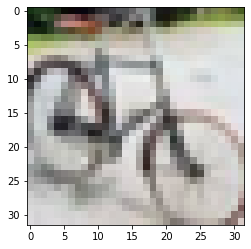

In [27]:
#@title Test qualitative results {run : 'auto'}
datapoint_number = 27 #@param{type : "integer"}
image, gt = cifar100_test[datapoint_number]
image_pixels = torchvision.transforms.functional.to_pil_image(image)
plt.imshow(image_pixels)
pr = loaded_student.mixer(image.unsqueeze(0).float())
#print(pr)
dataset.dataset.classes[gt],  dataset.dataset.classes[pr.argmax().item()]